In [2]:
import os
import pandas as pd
import numpy as np

# INPUT (đã có từ bước trước)
CLUSTER_INPUT = "../outputs/tables/cluster_input_clean.csv"

# OUTPUT tables
OUT_TABLE_DIR = "../outputs/tables"
OUT_FIG_DIR = "../outputs/figures"
os.makedirs(OUT_TABLE_DIR, exist_ok=True)
os.makedirs(OUT_FIG_DIR, exist_ok=True)

score_cols = [
    "Liquidity_Score",
    "Leverage_Score",
    "Efficiency_Score",
    "Size_Score",
    "Profitability_Score"
]

In [3]:
from sklearn.cluster import KMeans

def cluster_one_group(group, n_clusters=3, random_state=42):
    X = group[score_cols].values
    kmeans = KMeans(n_clusters=n_clusters, random_state=random_state, n_init=20)
    labels = kmeans.fit_predict(X)

    group = group.copy()
    group["cluster_raw"] = labels

    cluster_means = (
        group.groupby("cluster_raw")["Composite_Score"]
        .mean()
        .sort_values()
    )
    label_map = {old: new for new, old in enumerate(cluster_means.index)}
    group["cluster"] = group["cluster_raw"].map(label_map)
    return group

df = pd.read_csv(CLUSTER_INPUT)

# nếu chưa có composite thì tạo
if "Composite_Score" not in df.columns:
    df["Composite_Score"] = df[score_cols].mean(axis=1, skipna=True)

clustered = []
for (industry, year), g in df.groupby(["Ngành ICB - cấp 1", "Năm"]):
    if len(g) < 10:
        continue
    clustered.append(cluster_one_group(g))

df_clustered = pd.concat(clustered, ignore_index=True)
cluster_labels_path = f"{OUT_TABLE_DIR}/cluster_labels.csv"
df_clustered.to_csv(cluster_labels_path, index=False, encoding="utf-8-sig")
print("Saved:", cluster_labels_path, "| shape:", df_clustered.shape)

Saved: ../outputs/tables/cluster_labels.csv | shape: (1342, 13)


In [4]:
df = df_clustered.sort_values(["Mã", "Ngành ICB - cấp 1", "Năm"]).copy()

df["cluster_next"] = df.groupby(["Mã", "Ngành ICB - cấp 1"])["cluster"].shift(-1)
df["Năm_next"] = df.groupby(["Mã", "Ngành ICB - cấp 1"])["Năm"].shift(-1)

migration_df = df.dropna(subset=["cluster_next"]).copy()
migration_df["cluster_next"] = migration_df["cluster_next"].astype(int)

migration_path = f"{OUT_TABLE_DIR}/migration_records.csv"
migration_df.to_csv(migration_path, index=False, encoding="utf-8-sig")
print("Saved:", migration_path, "| shape:", migration_df.shape)

def migration_matrix(data):
    return (
        pd.crosstab(data["cluster"], data["cluster_next"], normalize="index")
        .round(3)
    )

Saved: ../outputs/tables/migration_records.csv | shape: (985, 15)


In [5]:
import plotly.graph_objects as go

def build_sankey_for_industry_yearpair(migration_df, industry, year_t, year_t1, out_dir=OUT_FIG_DIR):
    tmp = migration_df[
        (migration_df["Ngành ICB - cấp 1"] == industry) &
        (migration_df["Năm"] == year_t) &
        (migration_df["Năm_next"] == year_t1)
    ].copy()

    flow = (
        tmp.groupby(["cluster", "cluster_next"])
           .size()
           .reset_index(name="value")
    )

    labels = ["Yếu (t)", "TB (t)", "Tốt (t)", "Yếu (t+1)", "TB (t+1)", "Tốt (t+1)"]
    source_map = {0: 0, 1: 1, 2: 2}
    target_map = {0: 3, 1: 4, 2: 5}

    sources = flow["cluster"].map(source_map)
    targets = flow["cluster_next"].map(target_map)
    values = flow["value"]

    fig = go.Figure(data=[go.Sankey(
        node=dict(pad=15, thickness=20, label=labels),
        link=dict(source=sources, target=targets, value=values)
    )])

    fig.update_layout(
        title_text=f"Dòng dịch chuyển trạng thái tài chính ({industry}) {year_t} → {year_t1}",
        font_size=12
    )

    safe_ind = industry.replace(" ", "_")
    html_path = f"{out_dir}/sankey_{safe_ind}_{year_t}_{year_t1}.html"
    fig.write_html(html_path, include_plotlyjs="cdn")
    return html_path

Sankey files:
- ../outputs/figures/sankey_Công_nghiệp_2021_2022.html
- ../outputs/figures/sankey_Công_nghiệp_2022_2023.html


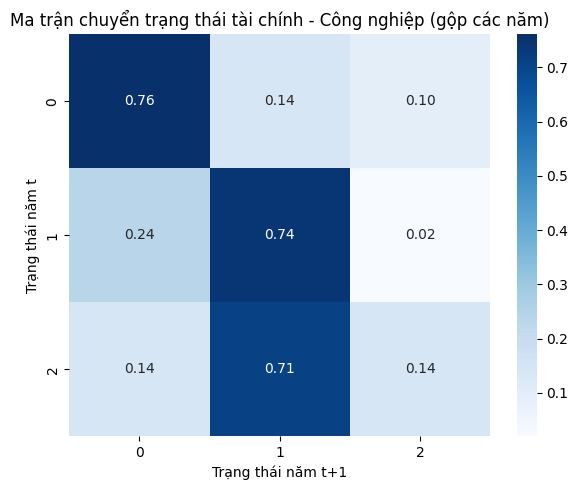

Saved: ../outputs/figures/heatmap_migration_Công_nghiệp.png


In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

demo_industry = "Công nghiệp"
years = sorted(migration_df["Năm"].unique())
year_pairs = list(zip(years[:-1], years[1:]))

# Sankey cho mọi cặp năm
paths = []
for y0, y1 in year_pairs:
    p = build_sankey_for_industry_yearpair(migration_df, demo_industry, y0, y1)
    paths.append(p)

print("Sankey files:")
for p in paths:
    print("-", p)

# Heatmap migration tổng (gộp các cặp năm) cho ngành demo
mat = migration_matrix(migration_df[migration_df["Ngành ICB - cấp 1"] == demo_industry])

plt.figure(figsize=(6,5))
sns.heatmap(mat, annot=True, fmt=".2f", cmap="Blues")
plt.title(f"Ma trận chuyển trạng thái tài chính - {demo_industry} (gộp các năm)")
plt.xlabel("Trạng thái năm t+1")
plt.ylabel("Trạng thái năm t")
plt.tight_layout()

heatmap_path = f"{OUT_FIG_DIR}/heatmap_migration_{demo_industry.replace(' ','_')}.png"
plt.savefig(heatmap_path, dpi=200)
plt.show()

print("Saved:", heatmap_path)

Tính ổn định trạng thái cao ở cả nhóm yếu và trung bình

Trạng thái 0 → 0: 0.76
→ 76% DN yếu tiếp tục ở trạng thái yếu

Trạng thái 1 → 1: 0.74
→ DN trung bình có xác suất duy trì cao nhất

👉 Cho thấy tồn tại tính ì trạng thái (state persistence) rõ rệt trong ngành Công nghiệp.

Cải thiện trạng thái có tồn tại nhưng không chiếm ưu thế

0 → 1: 0.14, 0 → 2: 0.10
→ DN yếu có cơ hội cải thiện, kể cả bật mạnh

Tuy nhiên, xác suất cải thiện thấp hơn nhiều so với xác suất bị “kẹt” ở trạng thái yếu

Trạng thái “tốt” khó bền vững

2 → 2: 0.14 → chỉ 14% DN tốt giữ được vị thế

2 → 1: 0.71 → phần lớn DN tốt rơi về trung bình

2 → 0: 0.14 → vẫn có rủi ro suy giảm mạnh

👉 Điều này cho thấy:

Trạng thái tài chính tốt trong ngành Công nghiệp mang tính ngắn hạn, chịu ảnh hưởng mạnh của chu kỳ và cạnh tranh.

Kết quả phân tích ma trận chuyển trạng thái tài chính cho thấy ngành Công nghiệp có mức độ ổn định cao ở các trạng thái yếu và trung bình, trong khi trạng thái tài chính tốt khó duy trì theo thời gian. Mặc dù tồn tại khả năng cải thiện trạng thái đối với một bộ phận doanh nghiệp yếu, xác suất chuyển lên nhóm tốt vẫn thấp. Điều này phản ánh đặc trưng cạnh tranh cao và áp lực duy trì hiệu quả tài chính trong ngành Công nghiệp.

In [7]:
# Ví dụ: ngành Công nghiệp, năm 2023
industry = "Công nghiệp"
year = 2023

rank_df = (
    df_clustered[
        (df_clustered["Ngành ICB - cấp 1"] == industry) &
        (df_clustered["Năm"] == year)
    ]
    .sort_values("Composite_Score", ascending=False)
    .assign(
        rank_in_industry=lambda x: range(1, len(x) + 1)
    )
)

rank_df[[
    "Mã", "Tên công ty", "Composite_Score", "cluster", "rank_in_industry"
]].head(10)

,Mã,Tên công ty,Composite_Score,cluster,rank_in_industry
229,NAV,Tấm lợp và gỗ Nam Việt,1.075554,2,1
186,BMP,Nhựa Bình Minh,0.956031,2,2
230,NCT,DV Hàng hóa Nội Bài,0.571834,2,3
207,GMD,Gemadept,0.562086,2,4
196,CTR,Công trình Viettel,0.482365,1,5
224,LGC,Đầu tư Cầu đường CII,0.454185,1,6
242,SC5,Xây dựng Số 5,0.385826,1,7
192,CLL,Cảng Cát Lái,0.384314,2,8
258,VGC,Tổng Công ty Viglacera,0.360150,1,9
206,GEX,Tập đoàn Gelex,0.346453,1,10


Bảng xếp hạng doanh nghiệp trong ngành Công nghiệp, năm 2023, dựa trên Composite_Score đã được chuẩn hoá theo ngành–năm.
Tức là:

DN chỉ so với DN cùng ngành

Không bị nhiễu bởi khác biệt ngành

Phản ánh vị thế tương đối nội ngành

In [8]:
import pandas as pd
import numpy as np

dfc = df_clustered.copy()

# industry stats theo (Ngành, Năm)
industry_stats = (
    dfc.groupby(["Ngành ICB - cấp 1", "Năm"])["Composite_Score"]
       .agg(industry_mean="mean", industry_median="median")
       .reset_index()
)

df_compare = dfc.merge(
    industry_stats,
    on=["Ngành ICB - cấp 1", "Năm"],
    how="left"
)

df_compare["gap_vs_industry_median"] = df_compare["Composite_Score"] - df_compare["industry_median"]

# rank nội ngành theo năm (1 = cao nhất)
df_compare["rank_in_industry"] = (
    df_compare.groupby(["Ngành ICB - cấp 1", "Năm"])["Composite_Score"]
              .rank(method="dense", ascending=False)
              .astype(int)
)

df_compare.head()

,Mã,Tên công ty,Sàn,Ngành ICB - cấp 1,Năm,Liquidity_Score,Leverage_Score,Efficiency_Score,Size_Score,Profitability_Score,Composite_Score,cluster_raw,cluster,industry_mean,industry_median,gap_vs_industry_median,rank_in_industry
0,ABR,Đầu tư Nhãn Hiệu Việt,HOSE,Công nghiệp,2021,0.344145,-0.422199,-0.296525,-1.358856,-0.112813,-0.369249,0,0,0.004266,0.027318,-0.396568,83
1,ACC,Đầu tư và XD Bình Dương ACC,HOSE,Công nghiệp,2021,-0.248609,0.171042,-0.296994,-0.439034,-0.258417,-0.214402,0,0,0.004266,0.027318,-0.241721,71
2,ADP,Sơn Á Đông,HOSE,Công nghiệp,2021,0.077587,-0.435463,0.234649,-0.862352,0.746338,-0.047848,2,1,0.004266,0.027318,-0.075166,59
3,APH,Tập đoàn An Phát Holdings,HOSE,Công nghiệp,2021,-0.114026,-0.037119,0.162233,1.618246,-0.484517,0.228963,1,2,0.004266,0.027318,0.201645,20
4,ASG,Tập đoàn ASG,HOSE,Công nghiệp,2021,-0.176398,-0.261589,-0.294486,0.010282,-0.554265,-0.255291,0,0,0.004266,0.027318,-0.282609,76


In [9]:
import ipywidgets as widgets
from IPython.display import display, clear_output
import matplotlib.pyplot as plt

# danh sách ngành
industries = sorted(df_compare["Ngành ICB - cấp 1"].dropna().unique().tolist())

industry_dd = widgets.Dropdown(
    options=industries,
    value=industries[0],
    description="Ngành:",
    layout=widgets.Layout(width="420px")
)

ticker_dd = widgets.Combobox(  # gõ nhanh mã
    options=[],
    description="Mã:",
    placeholder="Nhập hoặc chọn mã",
    layout=widgets.Layout(width="420px")
)

out = widgets.Output()

def update_tickers(*args):
    ind = industry_dd.value
    tickers = sorted(df_compare[df_compare["Ngành ICB - cấp 1"] == ind]["Mã"].unique().tolist())
    ticker_dd.options = tickers
    ticker_dd.value = tickers[0] if tickers else ""

def show_company(*args):
    with out:
        clear_output()
        ind = industry_dd.value
        code = ticker_dd.value

        if not code:
            print("Không có mã trong ngành này.")
            return

        d = df_compare[(df_compare["Ngành ICB - cấp 1"] == ind) & (df_compare["Mã"] == code)].copy()
        if d.empty:
            print("Không tìm thấy mã trong ngành đã chọn.")
            return

        d = d.sort_values("Năm")

        # info chung
        name = d["Tên công ty"].iloc[-1] if "Tên công ty" in d.columns else ""
        exchange = d["Sàn"].iloc[-1] if "Sàn" in d.columns else ""
        years = d["Năm"].tolist()
        last = d.iloc[-1]

        # block tóm tắt năm gần nhất
        print(f"Mã: {code} | Tên: {name} | Sàn: {exchange}")
        print(f"Ngành: {ind}")
        print("-" * 80)
        print(f"Năm gần nhất: {int(last['Năm'])}")
        print(f"  Cluster (0 yếu - 1 TB - 2 tốt): {int(last['cluster'])}")
        print(f"  Rank nội ngành: {int(last['rank_in_industry'])}")
        print(f"  Composite_Score: {last['Composite_Score']:.3f}")
        print(f"  Median ngành: {last['industry_median']:.3f}")
        print(f"  Gap vs median ngành: {last['gap_vs_industry_median']:.3f}")
        print("-" * 80)

        # bảng trajectory
        cols_show = [
            "Năm", "cluster", "rank_in_industry",
            "Composite_Score", "industry_median", "gap_vs_industry_median",
            "Liquidity_Score", "Leverage_Score", "Efficiency_Score", "Size_Score", "Profitability_Score"
        ]
        cols_show = [c for c in cols_show if c in d.columns]
        display(d[cols_show].reset_index(drop=True))

        # plot trajectory composite vs median ngành
        plt.figure(figsize=(8,4))
        plt.plot(d["Năm"], d["Composite_Score"], marker="o", label="Composite")
        plt.plot(d["Năm"], d["industry_median"], marker="o", label="Median ngành")
        plt.title(f"Quỹ đạo vị thế nội ngành: {code} ({ind})")
        plt.xlabel("Năm")
        plt.ylabel("Điểm (chuẩn hoá nội ngành)")
        plt.legend()
        plt.tight_layout()
        plt.show()

industry_dd.observe(update_tickers, names="value")
ticker_dd.observe(show_company, names="value")

update_tickers()
display(widgets.VBox([industry_dd, ticker_dd, out]))
show_company()


Nhận xét kết quả (mã ABR – Công nghiệp)

Cluster năm gần nhất: 0 (yếu)

Rank nội ngành: 86 (tức là khá thấp trong ngành)

Composite_Score âm và gap vs median âm
→ DN này tụt dưới mặt bằng ngành và đang thuộc nhóm yếu so với các DN cùng ngành.

📌 Ghi chú: đường Composite (màu xanh) nằm dưới median (màu cam) xuyên suốt → demo rất rõ.

In [10]:
import ipywidgets as widgets
from IPython.display import display, clear_output
import matplotlib.pyplot as plt

# --- PRECOMPUTE (giúp chạy nhanh) ---
industries = sorted(df_compare["Ngành ICB - cấp 1"].dropna().unique().tolist())

industry_to_tickers = (
    df_compare.groupby("Ngành ICB - cấp 1")["Mã"]
    .unique()
    .apply(lambda x: sorted(list(x)))
    .to_dict()
)

all_years = sorted(df_compare["Năm"].dropna().unique().tolist())
state_label = {0: "Yếu", 1: "Trung bình", 2: "Tốt"}

# --- WIDGETS ---
industry_dd = widgets.Dropdown(
    options=industries,
    value=industries[0],
    description="Ngành:",
    layout=widgets.Layout(width="420px")
)

ticker_dd = widgets.Dropdown(
    options=[],
    description="Mã:",
    layout=widgets.Layout(width="420px")
)

search_box = widgets.Text(
    value="",
    description="Search:",
    placeholder="Nhập mã (vd: BMP) rồi bấm Tìm",
    layout=widgets.Layout(width="420px")
)

search_btn = widgets.Button(
    description="Tìm",
    button_style="primary",
    layout=widgets.Layout(width="120px")
)

msg = widgets.HTML(value="")
out = widgets.Output()

def update_tickers(*args):
    ind = industry_dd.value
    tickers = industry_to_tickers.get(ind, [])
    ticker_dd.options = tickers
    ticker_dd.value = tickers[0] if tickers else None
    msg.value = ""

def show_company(code: str, ind: str):
    with out:
        clear_output(wait=True)

        if not code:
            print("Không có mã để hiển thị.")
            return

        d = df_compare[(df_compare["Ngành ICB - cấp 1"] == ind) & (df_compare["Mã"] == code)].copy()
        if d.empty:
            print("Không tìm thấy mã trong ngành đã chọn.")
            return

        d = d.sort_values("Năm")
        last = d.iloc[-1]

        name = d["Tên công ty"].iloc[-1] if "Tên công ty" in d.columns else ""
        exchange = d["Sàn"].iloc[-1] if "Sàn" in d.columns else ""
        years = d["Năm"].astype(int).tolist()

        missing_years = [y for y in all_years if y not in years]

        print(f"Mã: {code} | Tên: {name} | Sàn: {exchange}")
        print(f"Ngành: {ind}")
        if missing_years:
            print(f"Lưu ý: DN thiếu dữ liệu các năm: {missing_years} (không đủ chỉ số để phân cụm).")

        print("-" * 80)
        print(f"Năm gần nhất: {int(last['Năm'])}")
        cl = int(last["cluster"])
        print(f"  Trạng thái: {cl} - {state_label.get(cl, str(cl))}")
        print(f"  Rank nội ngành: {int(last['rank_in_industry'])}")
        print(f"  Composite_Score: {last['Composite_Score']:.3f}")
        print(f"  Median ngành: {last['industry_median']:.3f}")
        print(f"  Gap vs median ngành: {last['gap_vs_industry_median']:.3f}")
        print("-" * 80)

        d2 = d.copy()
        d2["state"] = d2["cluster"].map(state_label)

        cols_show = ["Năm", "state", "rank_in_industry", "Composite_Score", "industry_median", "gap_vs_industry_median"]
        display(d2[cols_show].reset_index(drop=True))

        plt.figure(figsize=(8,4))
        plt.plot(d2["Năm"], d2["Composite_Score"], marker="o", label="Composite")
        plt.plot(d2["Năm"], d2["industry_median"], marker="o", label="Median ngành")
        plt.title(f"Quỹ đạo vị thế nội ngành: {code} ({ind})")
        plt.xlabel("Năm")
        plt.ylabel("Điểm (chuẩn hoá nội ngành)")
        plt.legend()
        plt.tight_layout()
        plt.show()

        last_year = int(last["Năm"])
        top5 = (
            df_compare[(df_compare["Ngành ICB - cấp 1"] == ind) & (df_compare["Năm"] == last_year)]
            .sort_values("Composite_Score", ascending=False)
            [["Mã", "Tên công ty", "Composite_Score", "rank_in_industry", "cluster"]]
            .head(5)
            .copy()
        )
        top5["state"] = top5["cluster"].map(state_label)

        print("\nTop 5 DN trong ngành (năm gần nhất):")
        display(top5[["Mã","Tên công ty","Composite_Score","rank_in_industry","state"]].reset_index(drop=True))

def on_dropdown_change(*args):
    ind = industry_dd.value
    code = ticker_dd.value
    msg.value = ""
    if code:
        show_company(code, ind)

def on_search_click(btn):
    ind = industry_dd.value
    query = (search_box.value or "").strip().upper()

    if not query:
        msg.value = "<span style='color:#b91c1c;'>Bạn chưa nhập mã.</span>"
        return

    tickers = set(industry_to_tickers.get(ind, []))
    if query not in tickers:
        # gợi ý vài mã gần giống
        suggestions = [t for t in industry_to_tickers.get(ind, []) if query in t][:10]
        if suggestions:
            msg.value = f"<span style='color:#b91c1c;'>Không thấy mã <b>{query}</b> trong ngành này. Gợi ý: {', '.join(suggestions)}</span>"
        else:
            msg.value = f"<span style='color:#b91c1c;'>Không thấy mã <b>{query}</b> trong ngành này.</span>"
        return

    # sync dropdown và show
    msg.value = "<span style='color:#15803d;'>Đã tìm thấy mã.</span>"
    ticker_dd.value = query
    show_company(query, ind)

# events
industry_dd.observe(update_tickers, names="value")
ticker_dd.observe(on_dropdown_change, names="value")
search_btn.on_click(on_search_click)

# init
update_tickers()

ui = widgets.VBox([
    industry_dd,
    ticker_dd,
    widgets.HBox([search_box, search_btn]),
    msg,
    out
])

display(ui)
# hiển thị mặc định mã đầu tiên
if ticker_dd.value:
    show_company(ticker_dd.value, industry_dd.value)


Với mã ABR trong ngành Công nghiệp, doanh nghiệp này thuộc trạng thái tài chính yếu trong năm 2022, xếp hạng 86 trong ngành. Điểm tổng hợp luôn thấp hơn median ngành qua các năm, cho thấy ABR đang tụt hậu so với mặt bằng chung. Đồ thị cho thấy khoảng cách này không thu hẹp mà còn gia tăng, phản ánh áp lực cạnh tranh nội ngành.